In [2]:
!pip install optuna



### LAG WINDOW: 1 ###
Testing 54 parameter combinations for lag 1
Best params for lag 1: {'filters': 128, 'kernel_size': 1, 'lr': 0.001, 'epochs': 20, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


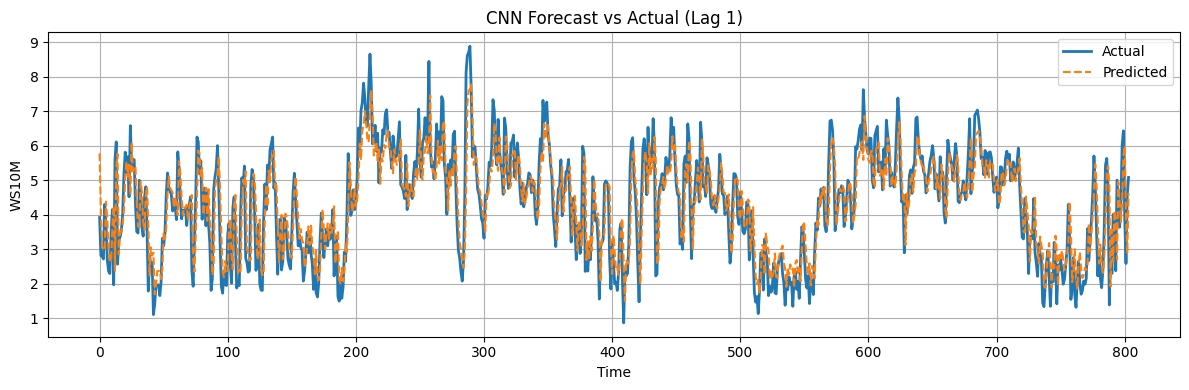



### LAG WINDOW: 2 ###
Testing 108 parameter combinations for lag 2
Best params for lag 2: {'filters': 32, 'kernel_size': 2, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


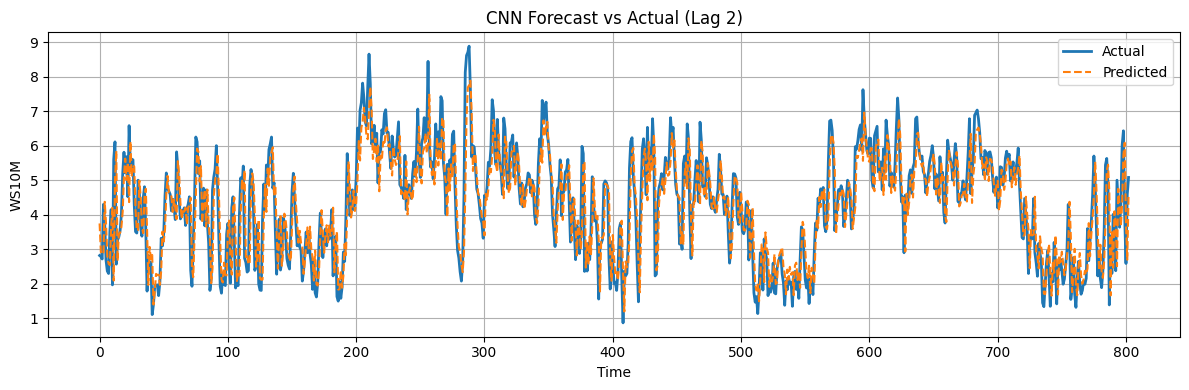



### LAG WINDOW: 3 ###
Testing 162 parameter combinations for lag 3
Best params for lag 3: {'filters': 128, 'kernel_size': 3, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


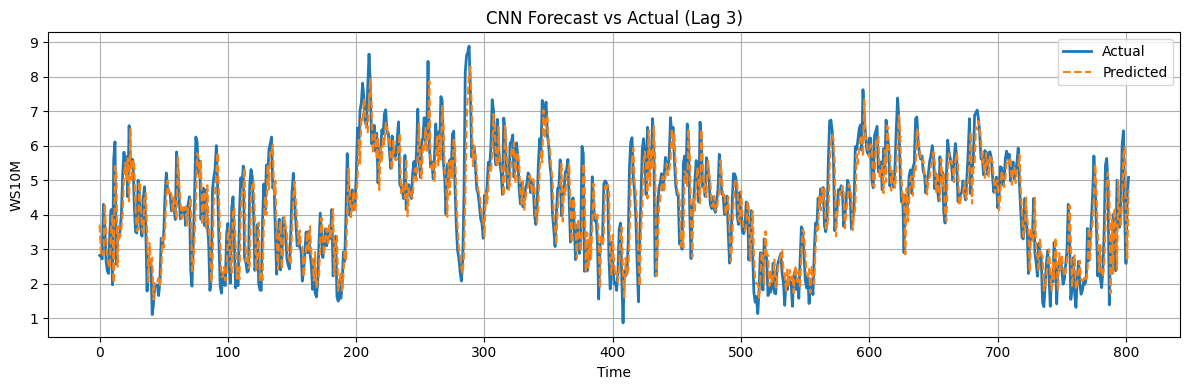



### LAG WINDOW: 4 ###
Testing 162 parameter combinations for lag 4
Best params for lag 4: {'filters': 128, 'kernel_size': 3, 'lr': 0.001, 'epochs': 20, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


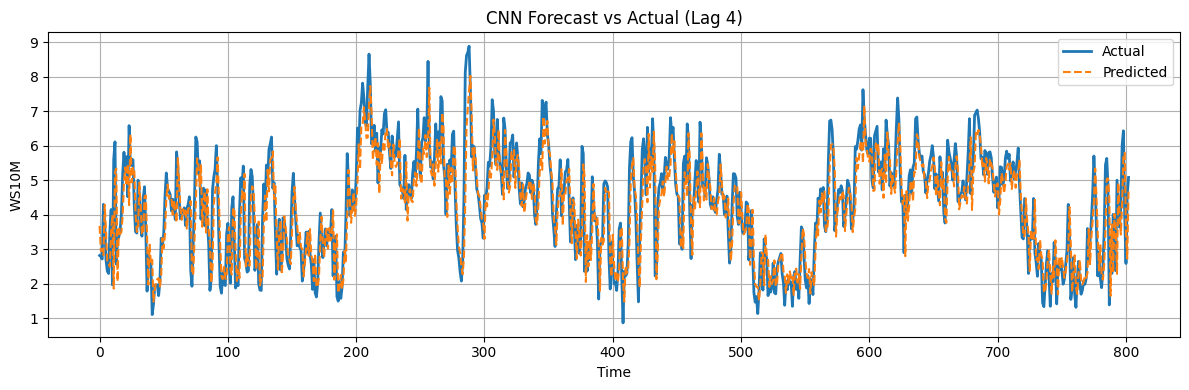



### LAG WINDOW: 5 ###
Testing 162 parameter combinations for lag 5
Best params for lag 5: {'filters': 32, 'kernel_size': 2, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


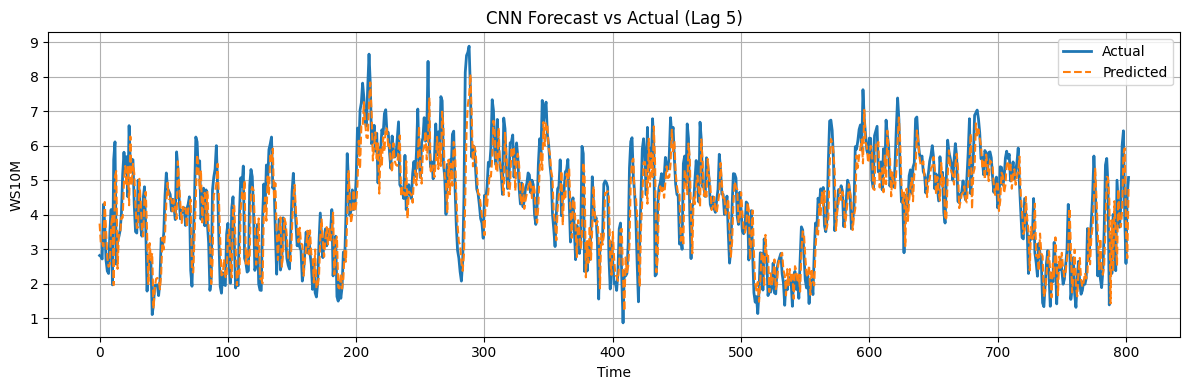



### LAG WINDOW: 6 ###
Testing 162 parameter combinations for lag 6
Best params for lag 6: {'filters': 32, 'kernel_size': 1, 'lr': 0.003, 'epochs': 15, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


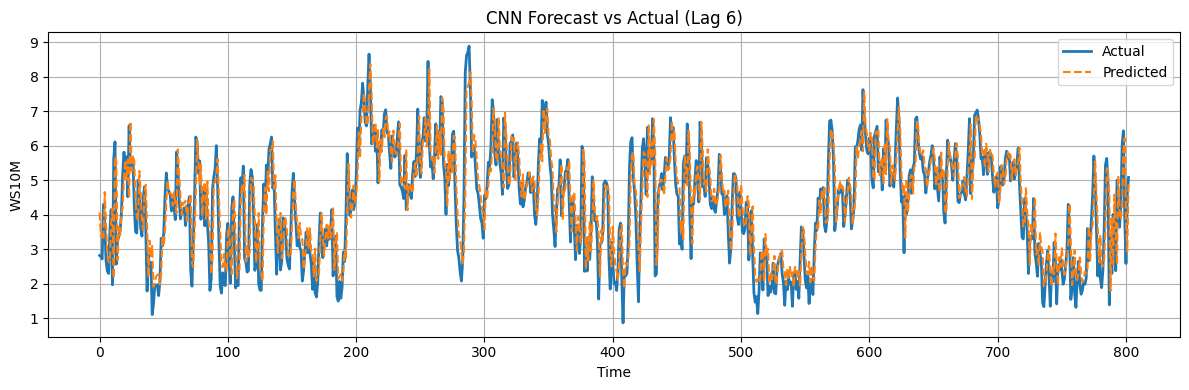



### LAG WINDOW: 7 ###
Testing 162 parameter combinations for lag 7


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from itertools import product

# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Load dataset
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(csv_url)

# Preprocessing
df = df.set_index('Date')
df = df.drop(columns=["YEAR", "MO", "DY"])
target_column = "WS10M"
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])
series = df[target_column].values

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Adjusted grid search parameter space
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [1, 2, 3],  # Include 1 for lag=1 case
    'lr': [1e-3, 3e-3, 1e-2],
    'epochs': [15, 20, 30],
    'batch_size': [16, 32]
}

# Loop over lags (window sizes) from 1 to 14
results = []

for lag in range(1, 15):
    print(f"\n\n### LAG WINDOW: {lag} ###")

    # Create sequences
    X, y = create_sequences(series, lag)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Grid search implementation
    best_val_loss = float('inf')
    best_params = None

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = [param_grid[name] for name in param_names]

    # Filter kernel sizes that are <= lag
    kernel_idx = param_names.index('kernel_size')
    param_values[kernel_idx] = [k for k in param_values[kernel_idx] if k <= lag]

    # Only proceed if we have valid combinations
    param_combinations = list(product(*param_values))

    if not param_combinations:
        print(f"No valid parameter combinations for lag {lag}, skipping...")
        continue

    print(f"Testing {len(param_combinations)} parameter combinations for lag {lag}")

    for params_values in param_combinations:
        params = dict(zip(param_names, params_values))

        # Reset seeds for each parameter combination
        tf.keras.backend.clear_session()
        np.random.seed(random_seed + lag * 100 + param_combinations.index(params_values))
        tf.random.set_seed(random_seed + lag * 100 + param_combinations.index(params_values))

        tscv = TimeSeriesSplit(n_splits=3)
        val_losses = []

        for train_idx, val_idx in tscv.split(X_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            # Create model with current parameters
            model = Sequential()
            model.add(Conv1D(filters=params['filters'],
                             kernel_size=params['kernel_size'],
                             activation='relu',
                             input_shape=X_train.shape[1:]))
            model.add(Flatten())
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=params['lr']),
                          loss='mse')

            model.fit(X_t, y_t,
                      epochs=params['epochs'],
                      batch_size=params['batch_size'],
                      verbose=0)

            val_loss = model.evaluate(X_v, y_v, verbose=0)
            val_losses.append(val_loss)

        mean_val_loss = np.mean(val_losses)

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_params = params

    print(f"Best params for lag {lag}: {best_params}")

    # Skip if no valid parameters were found
    if best_params is None:
        print(f"No valid models for lag {lag}, skipping...")
        continue

    # Train final model with best parameters
    tf.keras.backend.clear_session()
    np.random.seed(random_seed + lag * 1000)
    tf.random.set_seed(random_seed + lag * 1000)

    model = Sequential()
    model.add(Conv1D(filters=best_params['filters'],
                     kernel_size=best_params['kernel_size'],
                     activation='relu',
                     input_shape=X_train.shape[1:]))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_params['lr']),
                  loss='mse')
    model.fit(X_train, y_train, epochs=best_params['epochs'],
              batch_size=best_params['batch_size'], verbose=0)

    # Predict
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, y_pred_inv)

    # Store results
    results.append({
        'Lag': lag,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Params': best_params
    })

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv, label='Actual', linewidth=2)
    plt.plot(y_pred_inv, label='Predicted', linestyle='--')
    plt.title(f'CNN Forecast vs Actual (Lag {lag})')
    plt.xlabel("Time")
    plt.ylabel("WS10M")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display all performance metrics
results_df = pd.DataFrame(results)
print("\nSummary of CNN model performance for each lag window:\n")
print(results_df)



### LAG WINDOW: 1 ###
Testing 54 parameter combinations for lag 1
Best params for lag 1: {'filters': 128, 'kernel_size': 1, 'lr': 0.001, 'epochs': 20, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Performance metrics for lag 1:
RMSE: 0.8732
MSE: 0.7625
MAE: 0.6712
MAPE: 19.4403%
R-squared: 0.6834


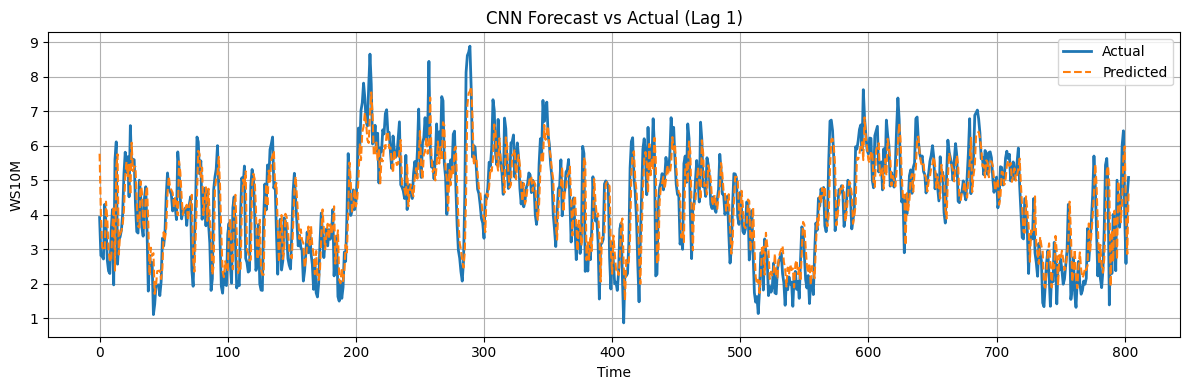



### LAG WINDOW: 2 ###
Testing 108 parameter combinations for lag 2
Best params for lag 2: {'filters': 32, 'kernel_size': 2, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Performance metrics for lag 2:
RMSE: 0.8744
MSE: 0.7646
MAE: 0.6707
MAPE: 18.9109%
R-squared: 0.6829


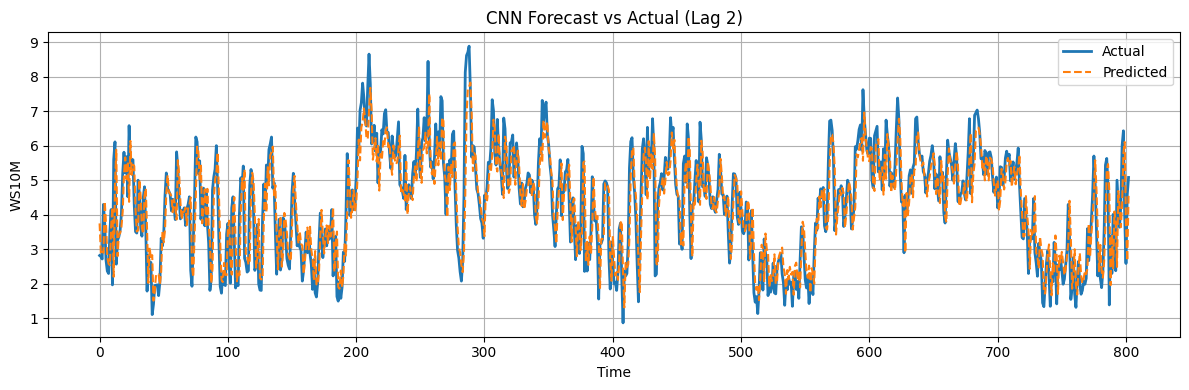



### LAG WINDOW: 3 ###
Testing 162 parameter combinations for lag 3
Best params for lag 3: {'filters': 128, 'kernel_size': 3, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Performance metrics for lag 3:
RMSE: 0.8704
MSE: 0.7576
MAE: 0.6671
MAPE: 18.4919%
R-squared: 0.6858


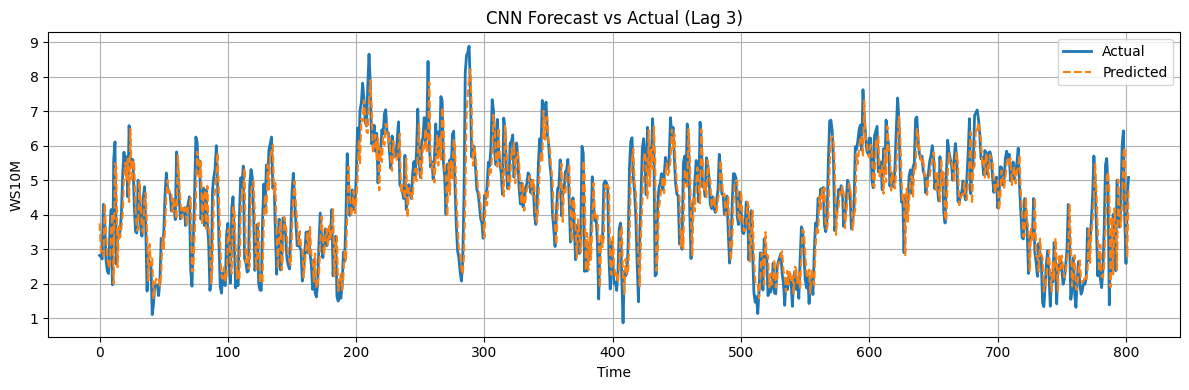



### LAG WINDOW: 4 ###
Testing 162 parameter combinations for lag 4
Best params for lag 4: {'filters': 128, 'kernel_size': 3, 'lr': 0.001, 'epochs': 20, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Performance metrics for lag 4:
RMSE: 0.8704
MSE: 0.7575
MAE: 0.6712
MAPE: 19.2848%
R-squared: 0.6859


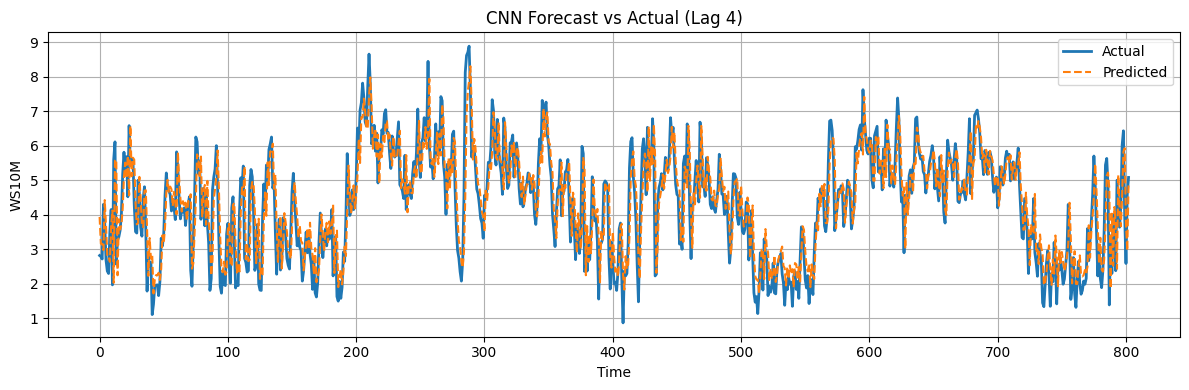



### LAG WINDOW: 5 ###
Testing 162 parameter combinations for lag 5
Best params for lag 5: {'filters': 32, 'kernel_size': 3, 'lr': 0.001, 'epochs': 20, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Performance metrics for lag 5:
RMSE: 0.8649
MSE: 0.7481
MAE: 0.6650
MAPE: 18.8962%
R-squared: 0.6898


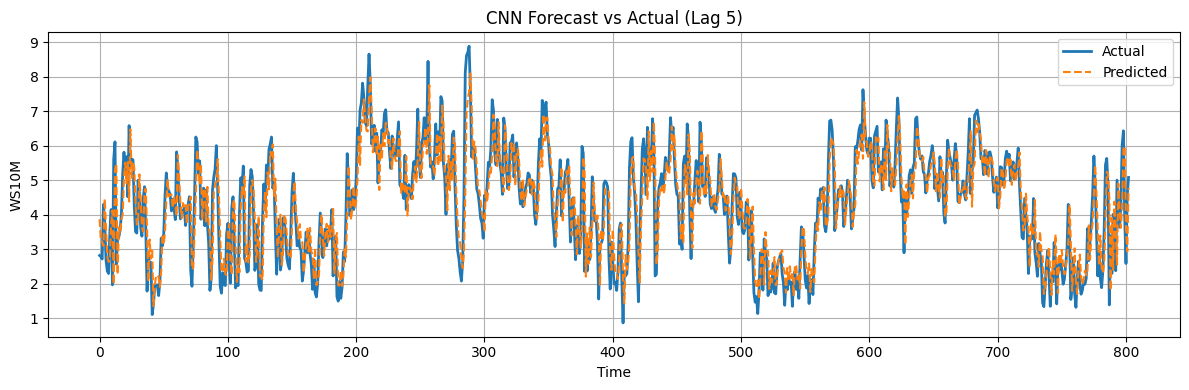



### LAG WINDOW: 6 ###
Testing 162 parameter combinations for lag 6
Best params for lag 6: {'filters': 64, 'kernel_size': 3, 'lr': 0.001, 'epochs': 20, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Performance metrics for lag 6:
RMSE: 0.8683
MSE: 0.7540
MAE: 0.6672
MAPE: 18.9328%
R-squared: 0.6873


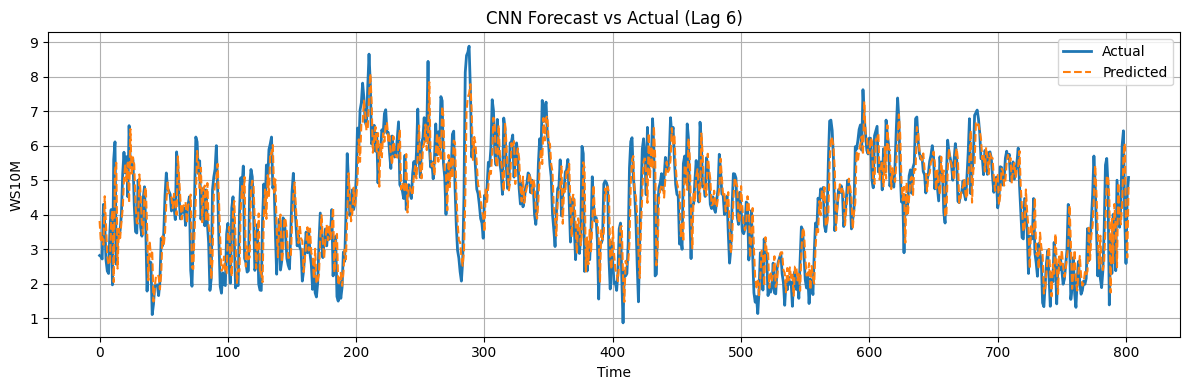



### LAG WINDOW: 7 ###
Testing 162 parameter combinations for lag 7


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from itertools import product

# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Load dataset
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(csv_url)

# Preprocessing
df = df.set_index('Date')
df = df.drop(columns=["YEAR", "MO", "DY"])
target_column = "WS10M"
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])
series = df[target_column].values

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Adjusted grid search parameter space
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [1, 2, 3],  # Include 1 for lag=1 case
    'lr': [1e-3, 3e-3, 1e-2],
    'epochs': [15, 20, 30],
    'batch_size': [16, 32]
}

# Loop over lags (window sizes) from 1 to 14
results = []

for lag in range(1, 15):
    print(f"\n\n### LAG WINDOW: {lag} ###")

    # Create sequences
    X, y = create_sequences(series, lag)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Grid search implementation
    best_val_loss = float('inf')
    best_params = None

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = [param_grid[name] for name in param_names]

    # Filter kernel sizes that are <= lag
    kernel_idx = param_names.index('kernel_size')
    param_values[kernel_idx] = [k for k in param_values[kernel_idx] if k <= lag]

    # Only proceed if we have valid combinations
    param_combinations = list(product(*param_values))

    if not param_combinations:
        print(f"No valid parameter combinations for lag {lag}, skipping...")
        continue

    print(f"Testing {len(param_combinations)} parameter combinations for lag {lag}")

    for params_values in param_combinations:
        params = dict(zip(param_names, params_values))

        # Reset seeds for each parameter combination
        tf.keras.backend.clear_session()
        np.random.seed(random_seed + lag * 100 + param_combinations.index(params_values))
        tf.random.set_seed(random_seed + lag * 100 + param_combinations.index(params_values))

        tscv = TimeSeriesSplit(n_splits=3)
        val_losses = []

        for train_idx, val_idx in tscv.split(X_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            # Create model with current parameters
            model = Sequential()
            model.add(Conv1D(filters=params['filters'],
                             kernel_size=params['kernel_size'],
                             activation='relu',
                             input_shape=X_train.shape[1:]))
            model.add(Flatten())
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=params['lr']),
                          loss='mse')

            model.fit(X_t, y_t,
                      epochs=params['epochs'],
                      batch_size=params['batch_size'],
                      verbose=0)

            val_loss = model.evaluate(X_v, y_v, verbose=0)
            val_losses.append(val_loss)

        mean_val_loss = np.mean(val_losses)

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_params = params

    print(f"Best params for lag {lag}: {best_params}")

    # Skip if no valid parameters were found
    if best_params is None:
        print(f"No valid models for lag {lag}, skipping...")
        continue

    # Train final model with best parameters
    tf.keras.backend.clear_session()
    np.random.seed(random_seed + lag * 1000)
    tf.random.set_seed(random_seed + lag * 1000)

    model = Sequential()
    model.add(Conv1D(filters=best_params['filters'],
                     kernel_size=best_params['kernel_size'],
                     activation='relu',
                     input_shape=X_train.shape[1:]))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_params['lr']),
                  loss='mse')
    model.fit(X_train, y_train, epochs=best_params['epochs'],
              batch_size=best_params['batch_size'], verbose=0)

    # Predict
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, y_pred_inv)

    # Print metrics for this trial
    print(f"\nPerformance metrics for lag {lag}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R-squared: {r2:.4f}")

    # Store results
    results.append({
        'Lag': lag,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Params': best_params
    })

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv, label='Actual', linewidth=2)
    plt.plot(y_pred_inv, label='Predicted', linestyle='--')
    plt.title(f'CNN Forecast vs Actual (Lag {lag})')
    plt.xlabel("Time")
    plt.ylabel("WS10M")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display all performance metrics
results_df = pd.DataFrame(results)
print("\nSummary of CNN model performance for each lag window:\n")
print(results_df)



### LAG WINDOW: 7 ###
Testing 162 parameter combinations for lag 7
Best params for lag 7: {'filters': 128, 'kernel_size': 3, 'lr': 0.001, 'epochs': 15, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Performance metrics for lag 7:
RMSE: 0.8668
MSE: 0.7513
MAE: 0.6672
MAPE: 18.3158%
R-squared: 0.6885


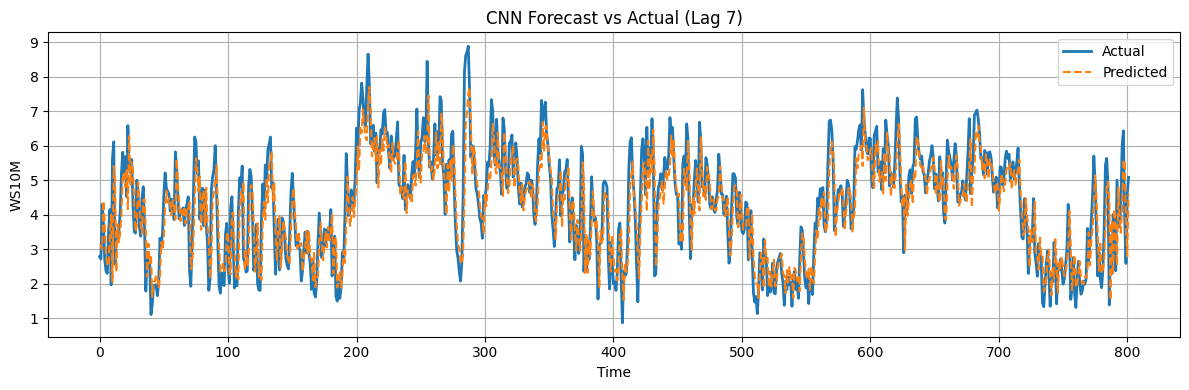



### LAG WINDOW: 8 ###
Testing 162 parameter combinations for lag 8
Best params for lag 8: {'filters': 64, 'kernel_size': 2, 'lr': 0.001, 'epochs': 15, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Performance metrics for lag 8:
RMSE: 0.8589
MSE: 0.7377
MAE: 0.6619
MAPE: 18.5180%
R-squared: 0.6941


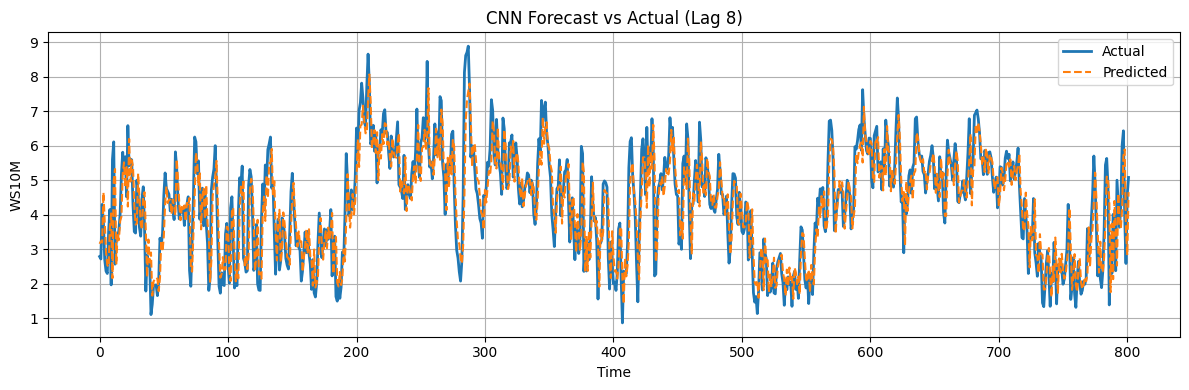



### LAG WINDOW: 9 ###
Testing 162 parameter combinations for lag 9
Best params for lag 9: {'filters': 128, 'kernel_size': 1, 'lr': 0.001, 'epochs': 15, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Performance metrics for lag 9:
RMSE: 0.8534
MSE: 0.7284
MAE: 0.6558
MAPE: 18.3710%
R-squared: 0.6980


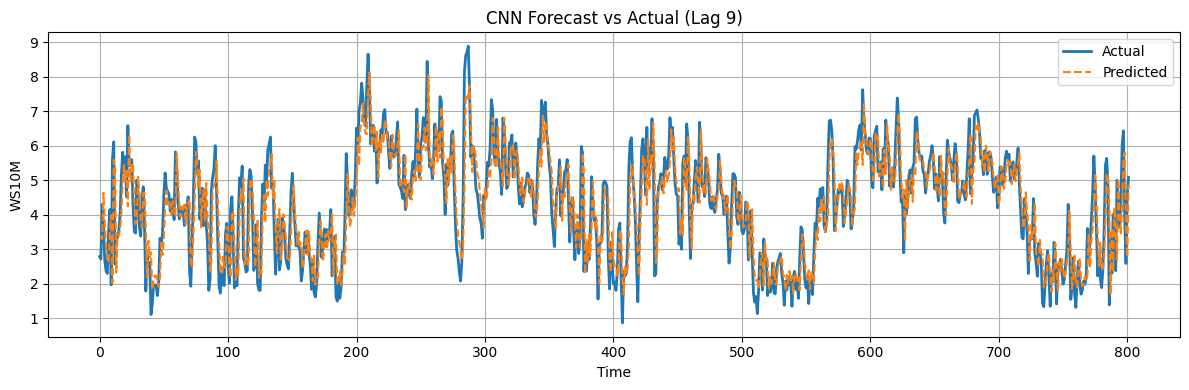



### LAG WINDOW: 10 ###
Testing 162 parameter combinations for lag 10
Best params for lag 10: {'filters': 128, 'kernel_size': 2, 'lr': 0.001, 'epochs': 20, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Performance metrics for lag 10:
RMSE: 0.8617
MSE: 0.7426
MAE: 0.6624
MAPE: 18.2281%
R-squared: 0.6921


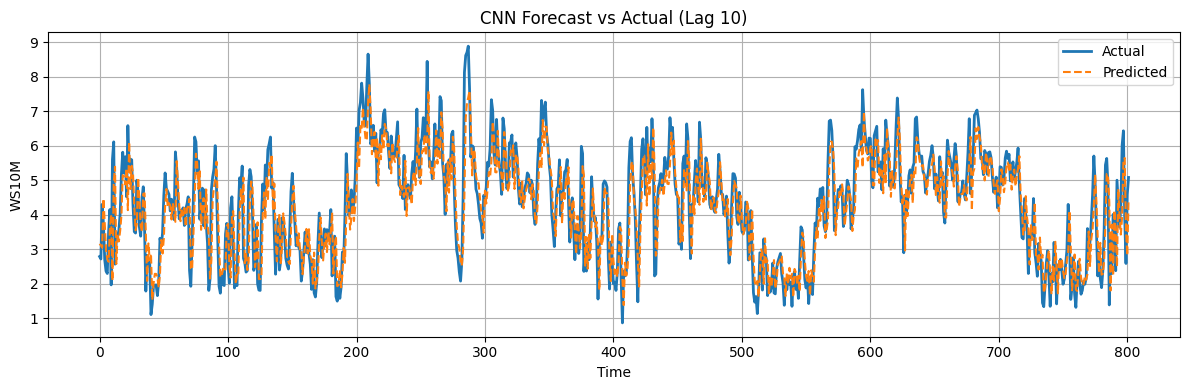



### LAG WINDOW: 11 ###
Testing 162 parameter combinations for lag 11
Best params for lag 11: {'filters': 64, 'kernel_size': 3, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Performance metrics for lag 11:
RMSE: 0.8701
MSE: 0.7570
MAE: 0.6710
MAPE: 19.3178%
R-squared: 0.6861


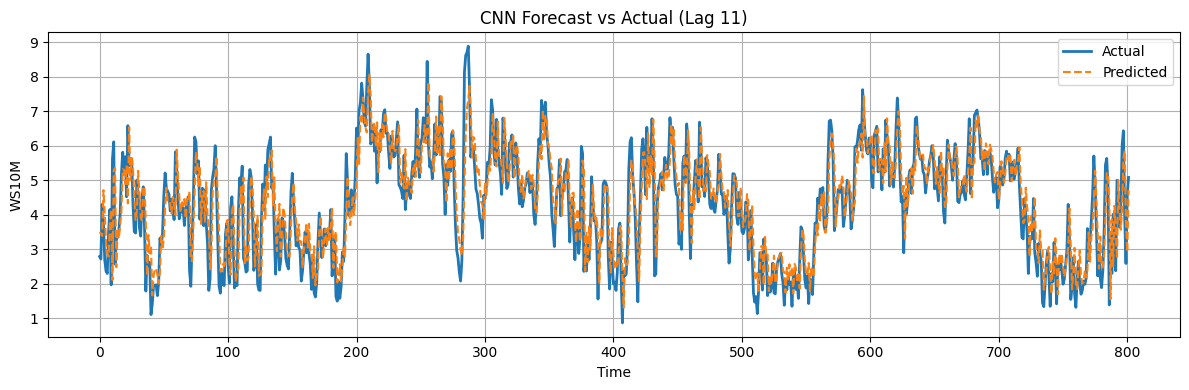



### LAG WINDOW: 12 ###
Testing 162 parameter combinations for lag 12


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from itertools import product

# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Load dataset
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(csv_url)

# Preprocessing
df = df.set_index('Date')
df = df.drop(columns=["YEAR", "MO", "DY"])
target_column = "WS10M"
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])
series = df[target_column].values

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Adjusted grid search parameter space
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [1, 2, 3],  # Include 1 for lag=1 case
    'lr': [1e-3, 3e-3, 1e-2],
    'epochs': [15, 20, 30],
    'batch_size': [16, 32]
}

# Loop over lags (window sizes) from 1 to 14
results = []

for lag in range(7, 15):
    print(f"\n\n### LAG WINDOW: {lag} ###")

    # Create sequences
    X, y = create_sequences(series, lag)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Grid search implementation
    best_val_loss = float('inf')
    best_params = None

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = [param_grid[name] for name in param_names]

    # Filter kernel sizes that are <= lag
    kernel_idx = param_names.index('kernel_size')
    param_values[kernel_idx] = [k for k in param_values[kernel_idx] if k <= lag]

    # Only proceed if we have valid combinations
    param_combinations = list(product(*param_values))

    if not param_combinations:
        print(f"No valid parameter combinations for lag {lag}, skipping...")
        continue

    print(f"Testing {len(param_combinations)} parameter combinations for lag {lag}")

    for params_values in param_combinations:
        params = dict(zip(param_names, params_values))

        # Reset seeds for each parameter combination
        tf.keras.backend.clear_session()
        np.random.seed(random_seed + lag * 100 + param_combinations.index(params_values))
        tf.random.set_seed(random_seed + lag * 100 + param_combinations.index(params_values))

        tscv = TimeSeriesSplit(n_splits=3)
        val_losses = []

        for train_idx, val_idx in tscv.split(X_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            # Create model with current parameters
            model = Sequential()
            model.add(Conv1D(filters=params['filters'],
                             kernel_size=params['kernel_size'],
                             activation='relu',
                             input_shape=X_train.shape[1:]))
            model.add(Flatten())
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=params['lr']),
                          loss='mse')

            model.fit(X_t, y_t,
                      epochs=params['epochs'],
                      batch_size=params['batch_size'],
                      verbose=0)

            val_loss = model.evaluate(X_v, y_v, verbose=0)
            val_losses.append(val_loss)

        mean_val_loss = np.mean(val_losses)

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_params = params

    print(f"Best params for lag {lag}: {best_params}")

    # Skip if no valid parameters were found
    if best_params is None:
        print(f"No valid models for lag {lag}, skipping...")
        continue

    # Train final model with best parameters
    tf.keras.backend.clear_session()
    np.random.seed(random_seed + lag * 1000)
    tf.random.set_seed(random_seed + lag * 1000)

    model = Sequential()
    model.add(Conv1D(filters=best_params['filters'],
                     kernel_size=best_params['kernel_size'],
                     activation='relu',
                     input_shape=X_train.shape[1:]))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_params['lr']),
                  loss='mse')
    model.fit(X_train, y_train, epochs=best_params['epochs'],
              batch_size=best_params['batch_size'], verbose=0)

    # Predict
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, y_pred_inv)

    # Print metrics for this trial
    print(f"\nPerformance metrics for lag {lag}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R-squared: {r2:.4f}")

    # Store results
    results.append({
        'Lag': lag,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Params': best_params
    })

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv, label='Actual', linewidth=2)
    plt.plot(y_pred_inv, label='Predicted', linestyle='--')
    plt.title(f'CNN Forecast vs Actual (Lag {lag})')
    plt.xlabel("Time")
    plt.ylabel("WS10M")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display all performance metrics
results_df = pd.DataFrame(results)
print("\nSummary of CNN model performance for each lag window:\n")
print(results_df)



### LAG WINDOW: 12 ###
Testing 162 parameter combinations for lag 12
Best params for lag 12: {'filters': 64, 'kernel_size': 3, 'lr': 0.001, 'epochs': 20, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Performance metrics for lag 12:
RMSE: 0.8767
MSE: 0.7686
MAE: 0.6712
MAPE: 18.1400%
R-squared: 0.6813


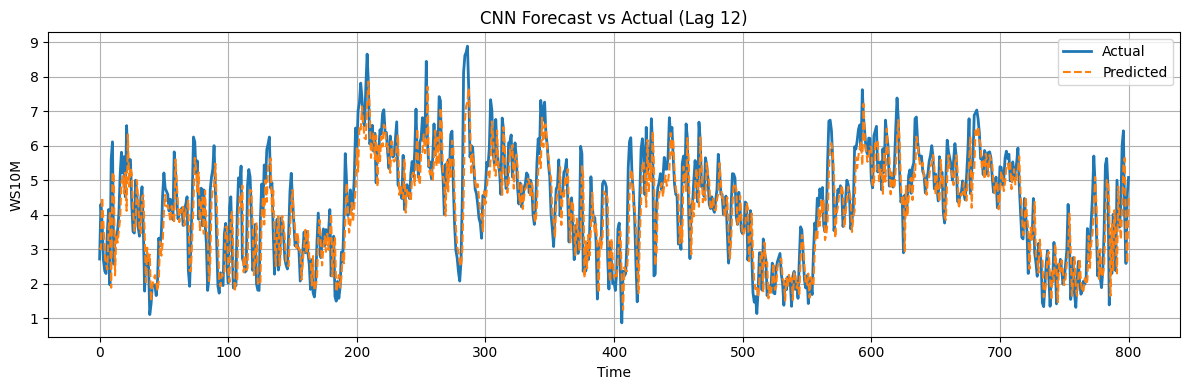



### LAG WINDOW: 13 ###
Testing 162 parameter combinations for lag 13
Best params for lag 13: {'filters': 32, 'kernel_size': 2, 'lr': 0.001, 'epochs': 15, 'batch_size': 16}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Performance metrics for lag 13:
RMSE: 0.8641
MSE: 0.7467
MAE: 0.6654
MAPE: 19.0273%
R-squared: 0.6904


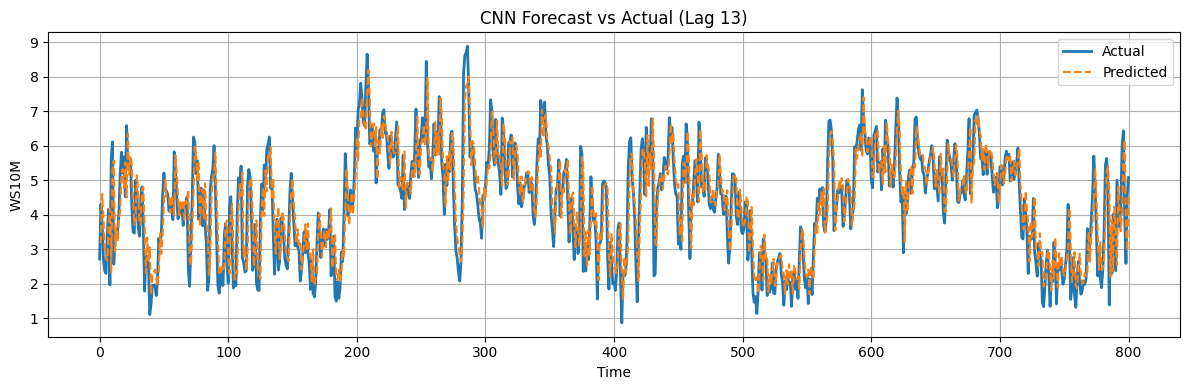



### LAG WINDOW: 14 ###
Testing 162 parameter combinations for lag 14
Best params for lag 14: {'filters': 64, 'kernel_size': 3, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Performance metrics for lag 14:
RMSE: 0.8638
MSE: 0.7462
MAE: 0.6657
MAPE: 18.8043%
R-squared: 0.6906


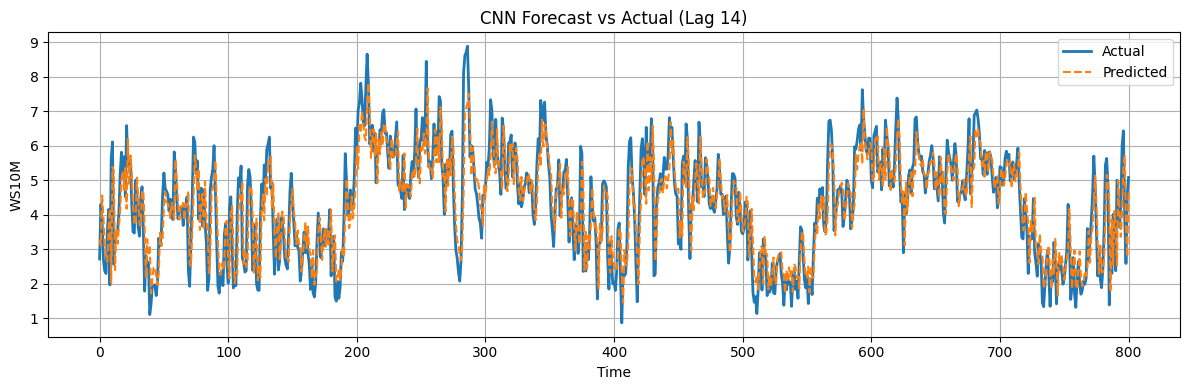


Summary of CNN model performance for each lag window:

   Lag       MSE      RMSE       MAE       MAPE        R2  \
0   12  0.768557  0.876674  0.671176  18.140026  0.681319   
1   13  0.746744  0.864144  0.665450  19.027340  0.690364   
2   14  0.746225  0.863843  0.665690  18.804303  0.690579   

                                              Params  
0  {'filters': 64, 'kernel_size': 3, 'lr': 0.001,...  
1  {'filters': 32, 'kernel_size': 2, 'lr': 0.001,...  
2  {'filters': 64, 'kernel_size': 3, 'lr': 0.001,...  


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from itertools import product

# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Load dataset
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(csv_url)

# Preprocessing
df = df.set_index('Date')
df = df.drop(columns=["YEAR", "MO", "DY"])
target_column = "WS10M"
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])
series = df[target_column].values

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Adjusted grid search parameter space
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [1, 2, 3],  # Include 1 for lag=1 case
    'lr': [1e-3, 3e-3, 1e-2],
    'epochs': [15, 20, 30],
    'batch_size': [16, 32]
}

# Loop over lags (window sizes) from 1 to 14
results = []

for lag in range(12, 15):
    print(f"\n\n### LAG WINDOW: {lag} ###")

    # Create sequences
    X, y = create_sequences(series, lag)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Grid search implementation
    best_val_loss = float('inf')
    best_params = None

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = [param_grid[name] for name in param_names]

    # Filter kernel sizes that are <= lag
    kernel_idx = param_names.index('kernel_size')
    param_values[kernel_idx] = [k for k in param_values[kernel_idx] if k <= lag]

    # Only proceed if we have valid combinations
    param_combinations = list(product(*param_values))

    if not param_combinations:
        print(f"No valid parameter combinations for lag {lag}, skipping...")
        continue

    print(f"Testing {len(param_combinations)} parameter combinations for lag {lag}")

    for params_values in param_combinations:
        params = dict(zip(param_names, params_values))

        # Reset seeds for each parameter combination
        tf.keras.backend.clear_session()
        np.random.seed(random_seed + lag * 100 + param_combinations.index(params_values))
        tf.random.set_seed(random_seed + lag * 100 + param_combinations.index(params_values))

        tscv = TimeSeriesSplit(n_splits=3)
        val_losses = []

        for train_idx, val_idx in tscv.split(X_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            # Create model with current parameters
            model = Sequential()
            model.add(Conv1D(filters=params['filters'],
                             kernel_size=params['kernel_size'],
                             activation='relu',
                             input_shape=X_train.shape[1:]))
            model.add(Flatten())
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=params['lr']),
                          loss='mse')

            model.fit(X_t, y_t,
                      epochs=params['epochs'],
                      batch_size=params['batch_size'],
                      verbose=0)

            val_loss = model.evaluate(X_v, y_v, verbose=0)
            val_losses.append(val_loss)

        mean_val_loss = np.mean(val_losses)

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_params = params

    print(f"Best params for lag {lag}: {best_params}")

    # Skip if no valid parameters were found
    if best_params is None:
        print(f"No valid models for lag {lag}, skipping...")
        continue

    # Train final model with best parameters
    tf.keras.backend.clear_session()
    np.random.seed(random_seed + lag * 1000)
    tf.random.set_seed(random_seed + lag * 1000)

    model = Sequential()
    model.add(Conv1D(filters=best_params['filters'],
                     kernel_size=best_params['kernel_size'],
                     activation='relu',
                     input_shape=X_train.shape[1:]))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_params['lr']),
                  loss='mse')
    model.fit(X_train, y_train, epochs=best_params['epochs'],
              batch_size=best_params['batch_size'], verbose=0)

    # Predict
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, y_pred_inv)

    # Print metrics for this trial
    print(f"\nPerformance metrics for lag {lag}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R-squared: {r2:.4f}")

    # Store results
    results.append({
        'Lag': lag,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Params': best_params
    })

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv, label='Actual', linewidth=2)
    plt.plot(y_pred_inv, label='Predicted', linestyle='--')
    plt.title(f'CNN Forecast vs Actual (Lag {lag})')
    plt.xlabel("Time")
    plt.ylabel("WS10M")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display all performance metrics
results_df = pd.DataFrame(results)
print("\nSummary of CNN model performance for each lag window:\n")
print(results_df)